# Regressão Linear

In [1]:
%matplotlib notebook

import pandas as pd
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from sklearn import datasets

SEED=200

plt.ion()

In [2]:
def minmax(x, column):
    diff = max(column) - min(column)
    return (x - min(column)) / diff

def rescale(df, columns):
    """
    df: dataframe com o dataset
    columns: nomes das colunas que devem ser reescaladas
    retorna o dataset reescalado
    """    
    # for each column
    for c in columns:
        # rescale each value (row)
        df[c] = df.apply(lambda row: minmax(row[c], df[c]), axis=1)
    return df

def line_equation(theta, x):
    """Equação da reta
    theta (nparray): Numpy array com os coeficientes da equação da reta (e.g. np.array([0.1, 0.3]))
    x (float): Valor float do eixo x
    retorna o valor do eixo y resultante 
    """
    return theta[0] + theta[1] * x

### A equação normal encontra os parâmetros ideais de forma analítica. A equação pode ser encontrada ao setar as derivadas parciais da função de custo para 0.

$$\Theta = (X^tX)^{-1}X^tf(x)$$

Muitas vezes pode não haver inversa. Quando isso acontece pode-se realizar aproximações numéricas.


In [3]:
def normal_equation(df):
    """Equação normal que calcula o resultado final ideal para os pesos
    df (dataframe): Pandas dataframe com os dados
    retorna um numpy array com os valores de theta resultantes da equação. Podem ser Nulos
    """
    return np.linalg.inv(df.T.dot(df)).dot(df.T).dot(Y)

### Primeiro passo é abrir os dados.
#### Nesse caso os dados estão em train_reg.csv. Um subset com os 200 primeiros elementos é retirado do csv.

In [4]:
"""Nao alterar"""
df = pd.read_csv('../regression_dataset/train_reg.csv')
df = rescale(df, columns=df.columns[:])

# Try the normal equation for the first 200
subset = df.iloc[0:200]
X, Y = subset.iloc[:,0], subset.iloc[:,1]

#### Em seguida deve ser utilizada a equação normal para encontrar os valores ideais de theta

<IPython.core.display.Javascript object>


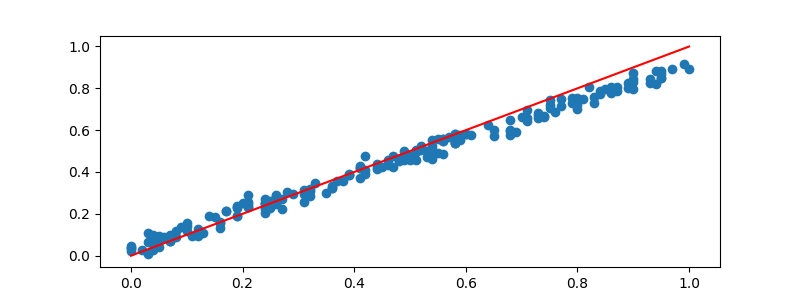

In [5]:
"""Nao alterar"""
theta = normal_equation(subset)

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.scatter(X, Y)

line = [0] * 2
line[0] = line_equation(theta, X.min())
line[1] = line_equation(theta, X.max())

drawn, = ax.plot((X.min(), X.max()), (line[0], line[1]), c='r')
fig.canvas.draw()

### A segunda abordagem é utilizando o Gradiente Descendente

In [6]:
def gradient_descent_step(df, theta, learning_rate=1e-5):
    """Realiza um passo do gradiente descendente
    
    Args:
        df (dataframe): Conjunto de dados (X, Y) => 699x2
        theta (nparray): Numpy Array com os valores de theta na iteração anterior do treinamento
        learning_rate (float): Taxa de aprendizado alpha
        
    Returns:
        nparray: um conjunto novo de Theta
        float: erro => cost function...
    """
    df_size = X.size
    df_X = X
    df_Y = Y

    y_hat_array = theta[0] + (theta[1] * df_X)

    cost = np.sum((y_hat_array - df_Y) ** 2) / (2 * df_size)

    t0 = theta[0] - learning_rate * (1/df_size) * np.sum(y_hat_array - df_Y)
    t1 = theta[1] - learning_rate * (1/df_size) * np.sum((y_hat_array - df_Y) * df_X)
    
    new_theta = np.array([t0, t1])

    return new_theta, cost

<IPython.core.display.Javascript object>


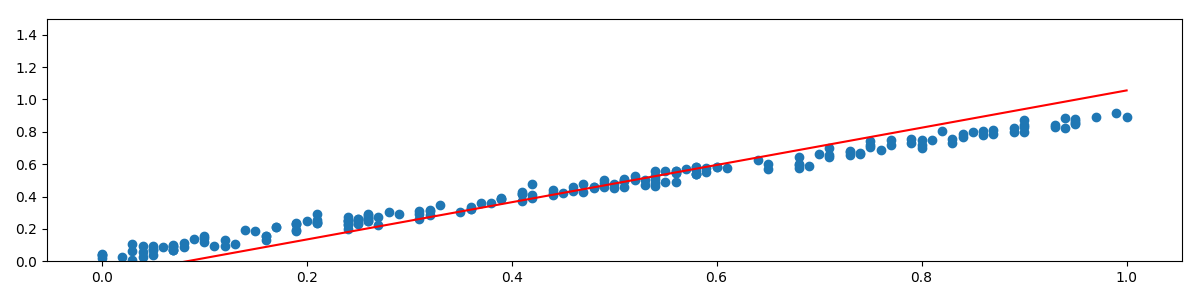

In [7]:
"""Nao alterar"""
# Cria o grafico e atualiza os pesos
fig = plt.figure(tight_layout=True, figsize=(12,3))
ax = fig.add_subplot(111)
ax.scatter(X, Y)

# Inicializa os pesos (theta) e plota a primeira reta do grafico
theta = [3, 4]
line = [0] * 2
line[0] = line_equation(theta, X.min())
line[1] = line_equation(theta, X.max())
drawn, = ax.plot((X.min(), X.max()), (line[0], line[1]), c='r')
ax.set_ylim((0, 1.5))

GRADIENT_DESCENT_ITERATIONS = 50
t = tqdm(range(0, GRADIENT_DESCENT_ITERATIONS))
for it in t:
    theta, error = gradient_descent_step(df, theta, learning_rate=0.5)
    t.set_description("Error: %.6s     " % error)
    
    # Atualiza o grafico
    line[0] = line_equation(theta, X.min())
    #print(line[0])
    line[1] = line_equation(theta, X.max())
    drawn.set_xdata((X.min(), X.max()))
    drawn.set_ydata((line[0], line[1]))
    fig.canvas.draw()
    
plt.close()

# Regressão Logística

## Carregar o dataset iris
### Escolher entre implementar rescale ou normalize

In [8]:
"""Rescale and normalize functions: implement the missing functions"""
def rescale(df, columns, maximum=None, minimum=None):
    """
    df: a dataframe with the dataset
    columns: the column names from the dataframe that should be rescaled
    maximum: a dictionary with the maximum value with each key representing a column
    minimum: a dictionary with the minimum value with each key representing a column
    """
    raise NotImplementedError("implementar rescale")

def normalize(df, columns, mean=None, std=None):
    """
    df: a dataframe with the dataset
    columns: the column names from the dataframe that should be normalized
    mean: a dictionary with the mean value with each key representing a column
    std: a dictionary with the standard deviation value with each key representing a column
    """

    # normalize each defined column 
    for c in columns:
        mean_c = mean[c] if mean and mean[c] else df.get(c).mean()
        std_c = std[c] if std and std[c] else df.get(c).std()
        if mean and std:
            df.get(c).apply(lambda x: ((x - mean_c) / std_c))
    return df, mean, std

In [9]:
"""Carrega o iris e deixa somente os dois primeiros atributos, além do atributo alvo. Nao alterar esta celula"""
iris = datasets.load_iris()

df_full = pd.DataFrame(data=np.c_[iris['data'], iris['target']],
                       columns=iris['feature_names'] + ['target'])
df_full = df_full[df_full.target != 2.]
df_full = df_full.loc[:,["sepal length (cm)", "sepal width (cm)", "target"]]

def get_train_test_inds(y, train_proportion=0.7):
    """
    y: coluna do atributo alvo
    retorna os indices de treino e teste estratificados pela classe
    """
    y=np.array(y)
    train_inds = np.zeros(len(y),dtype=bool)
    test_inds = np.zeros(len(y),dtype=bool)
    values = np.unique(y)
    for value in values:
        value_inds = np.nonzero(y==value)[0]
        np.random.shuffle(value_inds)
        n = int(train_proportion*len(value_inds))

        train_inds[value_inds[:n]]=True
        test_inds[value_inds[n:]]=True

    return train_inds,test_inds


train_inds, test_inds = get_train_test_inds(df_full.loc[:, "target"])
df_full[['target']] = df_full[['target']].astype(int)
df = df_full[train_inds]

df_val = df_full[test_inds]

In [10]:
"""Use este trecho no caso de optar por reescalar"""
# df, maximum, minimum = rescale(df, df.columns[0:4])
# df_val, _, _ = rescale(df_val, df_val.columns[0:4], maximum, minimum)

"""Use este trecho no caso de optar por normalizar"""
df, mean, std = normalize(df, df.columns[0:2])
df_val, _, _ = normalize(df_val, df_val.columns[0:2], mean, std)

In [11]:
"""Função de Ativação Sigmoidal"""
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Implementação da classe de regressão logística

In [12]:
class LogReg(object):
    def __init__(self, input_size, learning_rate=1e-1, sigma=1, weight_decay=0.01):
        self.weight_decay = weight_decay
        self.sigma = sigma
        self.learning_rate = learning_rate
        self.theta = sigma * np.random.randn(input_size)
        self.bias = np.zeros(1)
        self.grads = {}
    
    def forward(self, x):
        """
        x: entrada da rede neural 10x2 => wheigts (batch_size, numero_de_classes)
        retorna as probabilidades de cada classe 
        """
        line = x.dot(self.theta.T) + self.bias
        activation = sigmoid(line) # 10x1
        
        return activation
       
    def backward(self, y):
        """
        y: indices das classes esperadas (batch_size, 1)
        retorna o loss e o dicionario de gradientes
        """
        # forward predictions
        y_hat = predictions
        # number of values
        N = y.size
                
        #update grads
        
        # theta j function
        w_decay = (self.weight_decay / N) * self.theta
        self.grads['w'] = (batch.values.T.dot(y_hat - y) / N) + w_decay

        # theta 0 function
        self.grads['b'] = ((y_hat - y) * self.bias).mean()

        # decay function used in the loss function
        loss_decay = (self.weight_decay / (2 * N)) * np.sum(self.theta ** 2)
        # regularized loss function
        loss = -(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat)).mean() + loss_decay
        
        return loss, self.grads
        
    def optimize(self):
        self.bias = self.bias - self.learning_rate*self.grads["b"]
        self.theta = self.theta - self.learning_rate*self.grads["w"]
        
    
logreg = LogReg(2, sigma=1, weight_decay=0.01)

### Executar as iterações do Gradiente Descendente

<IPython.core.display.Javascript object>


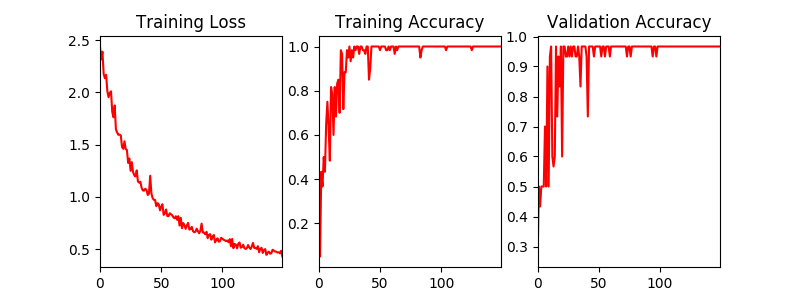

/Users/arielril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
/Users/arielril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0
/Users/arielril/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:70: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0


In [13]:
"""Alterar estes hiperparametros"""
epochs = 150
batch_size = 20
""""""

"""Nao alterar abaixo"""
# Cria o grafico e atualiza os pesos
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8,3))
ax1.set_title('Training Loss')
ax2.set_title('Training Accuracy')
ax3.set_title('Validation Accuracy')

t = tqdm(range(epochs))

losses = []
training_accuracy = []
accuracy = []

drawn, = ax1.plot(np.arange(0), losses, c='r')
drawn2, = ax2.plot(np.arange(0), training_accuracy, c='r')
drawn3, = ax3.plot(np.arange(0), accuracy, c='r')

# Loop de treinamento
for e in t:
    df = df.sample(frac=1., random_state=SEED)
    total_loss = 0
    correct = 0
    total = 0
    # Loop da epoca
    for i in range(0, df.shape[0]-batch_size, batch_size):
        total += batch_size
        batch = df.iloc[i:(i+batch_size), :]
        y = df.iloc[i:(i+batch_size)]
        y = y.loc[:, "target"]
        batch = batch.drop(["target"], axis=1)
        predictions = logreg.forward(batch.values)
        loss, grads = logreg.backward(y)
        total_loss += loss
        logreg.optimize()
        correct += sum(y.values == (predictions > 0.5))
    
    # Atualiza estatisticas e graficos
    training_accuracy.append(correct/total)
    losses.append(total_loss)
    t.set_description('Loss: %.3f' % total_loss)
    drawn.set_data((np.arange(len(losses)), losses))
    ax1.relim()
    ax1.set_xlim((0, e))
    ax1.autoscale_view()
    
    drawn2.set_data((np.arange(len(training_accuracy)), training_accuracy))
    ax2.relim()
    ax2.set_xlim((0, e))
    ax2.autoscale_view()
    #fig.canvas.draw()
    
    
    ### VALIDACAO ###
    batch = df_val
    y = df_val.loc[:, "target"]
    batch = batch.drop(["target"], axis=1)

    predictions = logreg.forward(batch.values)
    correct = np.sum(y.values == (predictions > 0.5))
    accuracy.append(correct/df_val.shape[0])
    
    # Atualiza graficos
    drawn3.set_data((np.arange(len(accuracy)), accuracy))
    ax3.relim()
    ax3.set_xlim((0, e))
    ax3.autoscale_view()
    fig.canvas.draw()

# É possível analisar a fronteira de decisão do classificador gerado. Este tipo de análise contribui para interpretação do classificador.

<IPython.core.display.Javascript object>


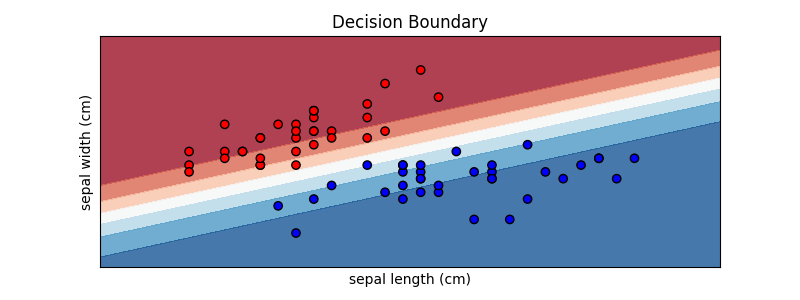

Text(0, 0.5, 'sepal width (cm)')

In [14]:
"""Nao alterar"""
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

h = .02

values = df.values
y = df.loc[:, "target"]
X1 = values[:, 0]
X2 = values[:, 1]

# Gera pontos interpolados para geracao da fronteira de decisao
x1_min, x1_max = X1.min() - .5, X1.max() + .5
x2_min, x2_max = X2.min() - .5, X2.max() + .5
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, h),
                       np.arange(x2_min, x2_max, h))


# Prediz a probabilidade dos pontos
points = np.c_[xx1.ravel(), xx2.ravel()]
predictions = logreg.forward(points)
predictions = predictions.reshape(xx1.shape)

# Gera o grafico
fig = plt.figure(figsize=(8, 3))
ax = plt.subplot(1, 1, 1)

ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Decision Boundary')

cm_bright = ListedColormap(['#FF0000', '#0000FF'])
cm = plt.cm.RdBu

ax.contourf(xx1, xx2, predictions, cmap=cm, alpha=.8)

ax.scatter(X1, X2, c=y, cmap=cm_bright, edgecolors='k')

ax.set_xlim(xx1.min(), xx1.max())
ax.set_ylim(xx2.min(), xx2.max())
ax.set_xticks(())
ax.set_yticks(())

ax.set_xlabel(df.columns[0])
ax.set_ylabel(df.columns[1])